In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Mount Google Drive
drive.mount('/content/drive')

# Định nghĩa đường dẫn đến dataset
DATASET_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(VAL_PATH, target_size=(224, 224), batch_size=32, class_mode='binary')

def build_model(base_model):
    base_model.trainable = True  # Mở khóa mô hình
    for layer in base_model.layers[:-20]:  # Chỉ fine-tune phần cuối
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model


# Chọn mô hình nền tảng
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model(base_model)

# Compile mô hình
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    callbacks=[early_stop]
)

# Lưu mô hình vào Google Drive
model.save("/content/drive/MyDrive/xray_pneumonia_model.h5")

# Grad-CAM

def grad_cam(model, img_array, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Hiển thị Grad-CAM cho tất cả ảnh trong thư mục test
def display_gradcam_for_all_images(test_folder, model, layer_name='conv5_block16_concat'):
    for class_name in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, (224, 224))
                img_array = np.expand_dims(img_resized, axis=0) / 255.0

                heatmap = grad_cam(model, img_array, layer_name)
                heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
                heatmap = np.uint8(255 * heatmap)
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

                pred = model.predict(img_array)[0][0]

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(superimposed_img)
                plt.title(f"Grad-CAM - Prediction: {pred:.2%} Pneumonia")
                plt.axis("off")
                plt.show()

# Áp dụng Grad-CAM cho tất cả ảnh trong thư mục test
display_gradcam_for_all_images(TEST_PATH, model)

Mounted at /content/drive
Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1705s 10s/step - accuracy: 0.7738 - loss: 0.4803 - val_accuracy: 0.8125 - val_loss: 0.3236 - learning_rate: 1.0000e-04
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 133s 727ms/step - accuracy: 0.9190 - loss: 0.1985 - val_accuracy: 0.9375 - val_loss: 0.2617 - learning_rate: 1.0000e-04
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 121s 735ms/step - accuracy: 0.9488 - loss: 0.1390 - val_accuracy: 0.9375 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 121s 735ms/step - accuracy: 0.9544 - loss: 0.1139 - val_accuracy: 0.8750 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 119s 725ms/step - accuracy: 0.9672 - loss: 0.0974 - val_accuracy: 1.0000 - val_loss: 0.1732 - learning_rate: 1.0000e-04
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 141s 722ms/step - accuracy: 0.9668 - loss: 0.0898 - val_accuracy: 0.9375 - val_loss: 0.1804 - learning_rate: 1.0000e-04
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step


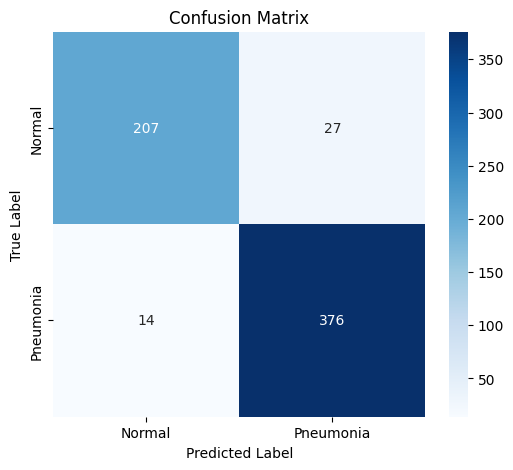

              precision    recall  f1-score   support

      Normal       0.94      0.88      0.91       234
   Pneumonia       0.93      0.96      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# Mount Google Drive
drive.mount('/content/drive')

# Định nghĩa đường dẫn đến dataset
DATASET_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(
    VAL_PATH, target_size=(224, 224), batch_size=32, class_mode='binary')

def build_model(base_model):
    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # Chỉ fine-tune phần cuối
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

# Chọn mô hình nền tảng
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model(base_model)

# Compile mô hình
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với EarlyStopping và ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

# Lưu mô hình vào Google Drive
model.save("/content/drive/MyDrive/xray_pneumonia_model.h5")

# Đánh giá mô hình trên tập kiểm tra
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# Dự đoán trên tập kiểm tra
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Hiển thị sơ đồ nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# In báo cáo phân loại
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))
